In [1]:
import os
import numpy as np
from scipy.fftpack import fft
from scipy.io import wavfile
from scipy import signal
from glob import glob
import re
import pandas as pd
import gc
from scipy.io import wavfile

from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
import keras

Using TensorFlow backend.


In [2]:
from pathlib import Path
import time

from scipy.io import wavfile
import numpy as np
import pandas as pd
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

import keras

from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dense, Input, Dropout, Flatten
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

In [3]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
DATADIR = '../raw_data' # unzipped train and test data
#OUTDIR = './model-k' # just a random name

POSSIBLE_LABELS = 'yes no up down left right on off stop go silence unknown'.split()
id2name = {i: name for i, name in enumerate(POSSIBLE_LABELS)}
name2id = {name: i for i, name in id2name.items()}


def load_data(data_dir):
    """ Return 2 lists of tuples:
    [(class_id, user_id, path), ...] for train
    [(class_id, user_id, path), ...] for validation
    """
    # Just a simple regexp for paths with three groups:
    # prefix, label, user_id
    pattern = re.compile("(.+\/)?(\w+)\/([^_]+)_.+wav")
    all_files = glob(os.path.join(data_dir, 'train/audio/*/*wav'))

    with open(os.path.join(data_dir, 'train/validation_list.txt'), 'r') as fin:
        validation_files = fin.readlines()
    valset = set()
    for entry in validation_files:
        r = re.match(pattern, entry)
        if r:
            valset.add(r.group(3))

    possible = set(POSSIBLE_LABELS)
    train, val = [], []
    for entry in all_files:
        r = re.match(pattern, entry)
        if r:
            label, uid = r.group(2), r.group(3)
            if label == '_background_noise_':
                label = 'silence'
            if label not in possible:
                label = 'unknown'

            #label_id = name2id[label]

            sample = (label, uid, entry)
            if uid in valset:
                val.append(sample)
            else:
                train.append(sample)

    print('There are {} train and {} val samples'.format(len(train), len(val)))
    return train, val

trainset, valset = load_data(DATADIR)

There are 57929 train and 6798 val samples


In [6]:
train = pd.DataFrame.from_records(trainset, columns=['label', 'user_id', 'path'])

In [7]:
val = pd.DataFrame.from_records(valset, columns=['label', 'user_id', 'path'])

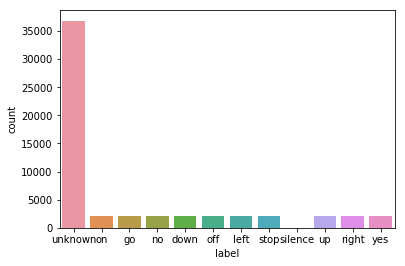

In [8]:
sns.countplot(x="label", data=train)

In [9]:
train[train.label == 'silence'].shape

(6, 3)

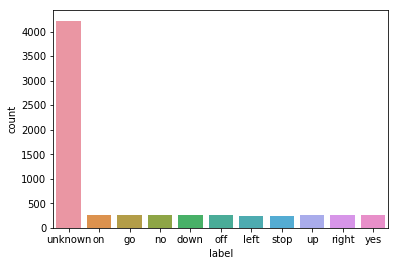

In [10]:
sns.countplot(x="label", data=val)

In [8]:
val[val.label == 'silence'].shape

(0, 3)

In [90]:
train_wavs = train[train.label != 'unknown'].sample(frac=0.15)

In [91]:
train_wavs = train_wavs[train_wavs['label'] != 'silence']

In [92]:
labels = train_wavs.label

In [93]:
labels.value_counts()

up       344
on       331
right    322
yes      320
off      319
left     318
down     316
stop     316
no       296
go       283
Name: label, dtype: int64

In [94]:
train_wavs = [wavfile.read(x)[1] for x in train_wavs.path]

In [95]:
len(train_wavs)

3165

In [96]:
data = [] 
for wav in train_wavs:
    if wav.size < 16000:
        d = np.pad(wav, (16000 - wav.size, 0), mode='constant')
    else:
        d = wav[0:16000]
    data.append(d)

In [97]:
del train_wavs
gc.collect()

0

In [98]:
matrix = np.array(data)

In [99]:
del data
gc.collect()

0

In [100]:
from sklearn.preprocessing import normalize

n_matrix = normalize(matrix,  axis=0)

In [101]:
del matrix

In [102]:
n_matrix.shape

(3165, 16000)

In [103]:
#np.savetxt('n_matrix.txt', n_matrix)
#n_matrix = np.loadtxt('n_matrix.txt')

In [105]:
from sklearn import decomposition


pca = decomposition.PCA(n_components=200)
#X_centered = X_train - X_train.mean(axis=0)
pca.fit(n_matrix)
n_matrix = pca.transform(n_matrix)

In [106]:
X_train, X_holdout, y_train, y_holdout = train_test_split(n_matrix, labels, stratify=labels, test_size=0.3,
random_state=1)

In [107]:
del n_matrix

In [108]:
gc.collect()

24

In [109]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=10, n_jobs=-1)

#knn.fit(X_train, y_train)

In [116]:
X_train.shape

(2215, 200)

In [110]:
from sklearn.model_selection import GridSearchCV

knn_params = {'n_neighbors': range(10, 25, 2), 'leaf_size': range(1, 20, 5), 'metric' : ['euclidean', 
                                                                                          'manhattan',
                                                                                          'minkowski',
                                                                                          'chebyshev'
                                                                                        ]}

knn_grid = GridSearchCV(knn, knn_params,
cv=3, n_jobs=-1,
verbose=True)


knn_grid.fit(X_train, y_train)

Fitting 3 folds for each of 128 candidates, totalling 384 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 384 out of 384 | elapsed:  4.6min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=10, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev'], 'leaf_size': range(1, 20, 5), 'n_neighbors': range(10, 25, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [111]:
knn_grid.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='euclidean',
           metric_params=None, n_jobs=-1, n_neighbors=12, p=2,
           weights='uniform')

In [112]:
knn_grid.best_score_

0.1291196388261851

In [113]:
from sklearn.metrics import accuracy_score

knn_pred = knn_grid.best_estimator_.predict(X_holdout)
accuracy_score(y_holdout, knn_pred)

0.13052631578947368

In [114]:
from sklearn.metrics import classification_report

print(classification_report(y_holdout, knn_pred, target_names=labels))

             precision    recall  f1-score   support

        yes       0.16      0.22      0.19        95
       down       0.11      0.13      0.12        85
       stop       0.13      0.19      0.15        95
       stop       0.10      0.09      0.09        89
       stop       0.16      0.12      0.14        96
         on       0.23      0.07      0.11        99
       left       0.08      0.09      0.08        97
        yes       0.17      0.09      0.12        95
         go       0.14      0.15      0.14       103
       stop       0.12      0.15      0.13        96

avg / total       0.14      0.13      0.13       950



/home/egor/tensorflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 10, does not match size of target_names, 3165
  .format(len(labels), len(target_names))


In [120]:
labels.unique()

array(['yes', 'down', 'stop', 'on', 'left', 'go', 'no', 'off', 'up',
       'right'], dtype=object)

In [121]:
from sklearn.metrics import classification_report

print(classification_report(y_holdout, knn_pred, target_names=labels.unique()))

             precision    recall  f1-score   support

        yes       0.16      0.22      0.19        95
       down       0.11      0.13      0.12        85
       stop       0.13      0.19      0.15        95
         on       0.10      0.09      0.09        89
       left       0.16      0.12      0.14        96
         go       0.23      0.07      0.11        99
         no       0.08      0.09      0.08        97
        off       0.17      0.09      0.12        95
         up       0.14      0.15      0.14       103
      right       0.12      0.15      0.13        96

avg / total       0.14      0.13      0.13       950



In [122]:
from sklearn.dummy import DummyClassifier

In [129]:
dc = DummyClassifier(strategy='stratified')
dc.fit(X_train, y_train)

dc_pred = dc.predict(X_holdout)
accuracy_score(y_holdout, dc_pred)

0.093684210526315786

In [130]:
from sklearn.metrics import classification_report

print(classification_report(y_holdout, dc_pred, target_names=labels.unique()))

             precision    recall  f1-score   support

        yes       0.10      0.12      0.11        95
       down       0.06      0.07      0.07        85
       stop       0.13      0.12      0.12        95
         on       0.08      0.07      0.07        89
       left       0.11      0.12      0.12        96
         go       0.08      0.08      0.08        99
         no       0.08      0.08      0.08        97
        off       0.06      0.06      0.06        95
         up       0.10      0.09      0.09       103
      right       0.13      0.12      0.13        96

avg / total       0.09      0.09      0.09       950



In [17]:
from sklearn import decomposition


pca = decomposition.PCA(n_components=2)
X_centered = X_train - X_train.mean(axis=0)
pca.fit(X_centered)
X_pca = pca.transform(X_centered)

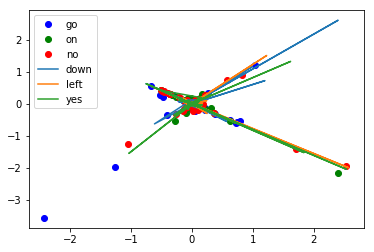

In [21]:
plt.plot(X_pca[y_train == 'go', 0], X_pca[y_train == 'go', 1], 'bo', label='go')
plt.plot(X_pca[y_train == 'on', 0], X_pca[y_train == 'on', 1], 'go', label='on')
plt.plot(X_pca[y_train == 'no', 0], X_pca[y_train == 'no', 1], 'ro', label='no')


plt.plot(X_pca[y_train == 'down', 0], X_pca[y_train == 'down', 1], label='down')
plt.plot(X_pca[y_train == 'left', 0], X_pca[y_train == 'left', 1], label='left')
plt.plot(X_pca[y_train == 'yes', 0], X_pca[y_train == 'yes', 1], label='yes')


plt.legend(loc=0);

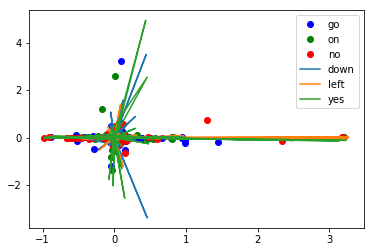

In [49]:
plt.plot(X_pca[labels == 'go', 0], X_pca[labels == 'go', 1], 'bo', label='go')
plt.plot(X_pca[labels == 'on', 0], X_pca[labels == 'on', 1], 'go', label='on')
plt.plot(X_pca[labels == 'no', 0], X_pca[labels == 'no', 1], 'ro', label='no')


plt.plot(X_pca[labels == 'down', 0], X_pca[labels == 'down', 1], label='down')
plt.plot(X_pca[labels == 'left', 0], X_pca[labels == 'left', 1], label='left')
plt.plot(X_pca[labels == 'yes', 0], X_pca[labels == 'yes', 1], label='yes')


plt.legend(loc=0);